<a href="https://colab.research.google.com/github/MinahilSadiq1/Twitter_Sentiment_Analysis/blob/main/sentiment_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# TWEET SENTIMENT ANALYSIS

### IMPORTING LIBRARIES

In [ ]:
#!pip install wordcloud

In [ ]:
#importing libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import string
import os
import re
import nltk
import pickle
from wordcloud import WordCloud,STOPWORDS
from sklearn.feature_extraction.text import CountVectorizer
from sklearn import metrics
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix

In [ ]:
#to check whether the file is in there
os.listdir()

['.ipynb_checkpoints',
 'icon.jpg',
 'LRC.pkl',
 'NBC.pkl',
 'ps.jpg',
 'RTC.pkl',
 'sentiment_analysis.ipynb',
 'SVM.pkl',
 'SVMp.pkl',
 'SVMr.pkl',
 'SVMs.pkl',
 'twitter_training.csv']

### LOADING DATA

In [ ]:
#data taken from online website (kaggle)
#getting the data
df = pd.read_csv("twitter_training.csv")
df.head()


,ID,entity,sentiment,content
0,2401,Borderlands,Positive,im getting on borderlands and i will murder yo...
1,2401,Borderlands,Positive,I am coming to the borders and I will kill you...
2,2401,Borderlands,Positive,im getting on borderlands and i will kill you ...
3,2401,Borderlands,Positive,im coming on borderlands and i will murder you...
4,2401,Borderlands,Positive,im getting on borderlands 2 and i will murder ...


In [ ]:
#(total rows, total columns)
df.shape

(74682, 4)

### CLEARING DATA

In [ ]:
#we are describing more values as the null values in our dataset
missing_values = [np.nan, "N/a", "n/a", "N/A", "NULL", "na", "NA", "it", "is", ".", "..", "this", "that", "you", "he", "she"]

In [ ]:
df = pd.read_csv("twitter_training.csv", na_values= missing_values)
df.head()

,ID,entity,sentiment,content
0,2401,Borderlands,Positive,im getting on borderlands and i will murder yo...
1,2401,Borderlands,Positive,I am coming to the borders and I will kill you...
2,2401,Borderlands,Positive,im getting on borderlands and i will kill you ...
3,2401,Borderlands,Positive,im coming on borderlands and i will murder you...
4,2401,Borderlands,Positive,im getting on borderlands 2 and i will murder ...


In [ ]:
#total number of instances according to the sentiments.
df.groupby('sentiment').size()

sentiment
Irrelevant    12990
Negative      22542
Neutral       18318
Positive      20832
dtype: int64

In [ ]:
#dropping columns not needed
df=df.drop('entity',axis=1)
df=df.drop('ID',axis=1)
df.head()

,sentiment,content
0,Positive,im getting on borderlands and i will murder yo...
1,Positive,I am coming to the borders and I will kill you...
2,Positive,im getting on borderlands and i will kill you ...
3,Positive,im coming on borderlands and i will murder you...
4,Positive,im getting on borderlands 2 and i will murder ...


In [ ]:
#we are not interested in the irrelevant instances, so to clean our data we are removing these irrelevant tweets.
df = df.loc[df['sentiment'] != 'Irrelevant']
df.shape

(61692, 2)

In [ ]:
#checking if there null values in it or not (true/false)
df.isnull().values.any()

True

In [ ]:
#claculating total number of null values in the dataframes
df.isnull().sum()

sentiment      0
content      752
dtype: int64

In [ ]:
#removing the instances having null values
df = df.dropna()
df.shape

(60940, 2)

In [ ]:
#removing duplicate instances to make our data more clean and noise free
df = df.drop_duplicates()
df.shape

(57459, 2)

In [ ]:
#converting sentiments(positive, negative, neutral into the labels(0,1,2))
possible_labels = df.sentiment.unique()

label_dict = {}
for index, possible_label in enumerate(possible_labels):
    label_dict[possible_label] = index
label_dict

{'Positive': 0, 'Neutral': 1, 'Negative': 2}

In [ ]:
df['label'] = df.sentiment.replace(label_dict)
df.head

In [ ]:
df.groupby('sentiment').size()

sentiment
Negative    21229
Neutral     17101
Positive    19129
dtype: int64

### VISUALIZING DATA

C:\Users\minahil\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


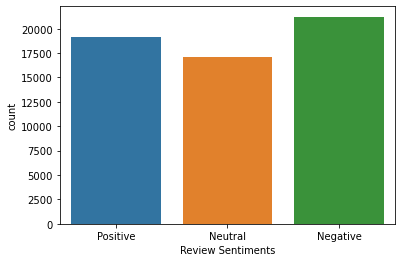

In [ ]:
class_names = ['Positive', 'Neutral', 'Negative']
ax = sns.countplot(df.label)
plt.xlabel('Review Sentiments')
ax.set_xticklabels(class_names);

# Working with textual data
### The preprocessing tasks we will perform:
* casing
* noise removal
* tokenization
* stopword removal
* text normalization(stemming and lemmatization)

In [ ]:
#after cleaning phase of data, now we have to make our text understandable by the classifier (natural language processing)
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('punkt')

In [ ]:
#creating stopwords set
stop_words = set(stopwords.words('English'))

In [ ]:
#creating function
def preprocess_tweet_text(tweet):

    #covert all text lowercase
    tweet = tweet.lower()

    #removing urls
    tweet = re.sub(r"http\S+|www\S+|https\S+", "" , str(tweet), flags=re.MULTILINE)

    #remove punctuations
    tweet = tweet.translate(str.maketrans("", "", string.punctuation))

    #removing @ and #
    tweet = re.sub(r"\@\w+|\#", "", tweet)

    #removing stopwords
    tweet_tokens = word_tokenize(tweet)
    filtered_words = [word for word in tweet_tokens if word not in stop_words]

    #stemming
    ps = PorterStemmer()
    stemmed_words = [ps.stem(w) for w in filtered_words]

    #lemmatizing
    lemmatizer = WordNetLemmatizer()
    lemma_words = [lemmatizer.lemmatize(w, pos='a') for w in stemmed_words]

    return " ".join(lemma_words)


In [ ]:
#created a seperate column for new processed data
df['processed content'] = df['content'].apply(lambda x:preprocess_tweet_text(x))
df.head()

,sentiment,content,label,processed content
0,Positive,im getting on borderlands and i will murder yo...,0,im get borderland murder
1,Positive,I am coming to the borders and I will kill you...,0,come border kill
2,Positive,im getting on borderlands and i will kill you ...,0,im get borderland kill
3,Positive,im coming on borderlands and i will murder you...,0,im come borderland murder
4,Positive,im getting on borderlands 2 and i will murder ...,0,im get borderland 2 murder


In [ ]:
#In 'x' having only our processed tweets and in y having our labels
x = df['processed content']
y = df['label']

### Wordcloud

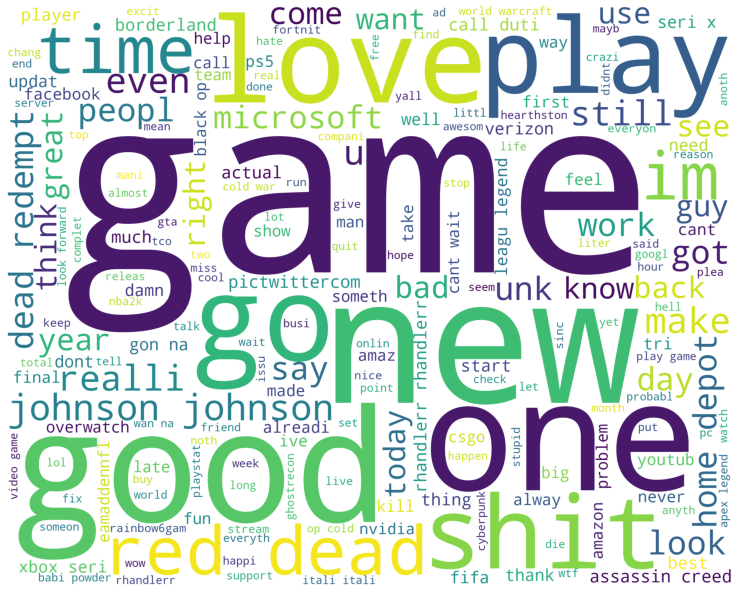

In [ ]:
#creating wordcloud of our processed tweets which show some major words from dataset
def wordcloud_draw(data, color = 'white'):
    words = ' '.join(data)
    cleaned_word = " ".join([word for word in words.split()
                            if 'http' not in word
                                and not word.startswith('@')
                                and not word.startswith('#')
                                and word != 'fuck'
                            ])
    wordcloud = WordCloud(stopwords=STOPWORDS,
                      background_color=color,
                      width=2500,
                      height=2000
                     ).generate(cleaned_word)
    plt.figure(1,figsize=(13, 13))
    plt.imshow(wordcloud)
    plt.axis('off')
    plt.show()

wordcloud_draw(x)

## Tokenization and Train_Test Split
* CountVectorizer

In [ ]:
#Using CountVectorizer to convert text into tokens/features
vect = CountVectorizer(stop_words='english', ngram_range = (1,1), max_df = .80, min_df = 4)

#splitting data in train and test
X_train, X_test, y_train, y_test = train_test_split(x,y, random_state=1, test_size= 0.2)

#Using training data to transform text into counts of features for each message
vect.fit(X_train)
X_train_dtm = vect.transform(X_train)
X_test_dtm = vect.transform(X_test)

In [ ]:
X_train

In [ ]:
X_test_dtm

<11492x10060 sparse matrix of type '<class 'numpy.int64'>'
	with 102553 stored elements in Compressed Sparse Row format>

# CLASSIFIERS

In [ ]:
#after all the processing, tokenizig and splitting, now train our models
#four models will b trained, then we will compare the accuracy
#import libraries for all classifiers used
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression

## SUPPORT VECTOR MACHINE
* SVM with linear kernel

In [ ]:
#Accuracy using SVM Model
SVM = SVC(C=1.0, kernel='linear', degree=3, gamma='auto')
SVM.fit(X_train_dtm, y_train)
y_pred = SVM.predict(X_test_dtm)
pickle.dump(SVM, open('SVM.pkl', 'wb'))

In [ ]:
print('\nSupport Vector Machine')
print('Accuracy Score: ',metrics.accuracy_score(y_test,y_pred)*100,'%',sep='')


Support Vector Machine
Accuracy Score: 81.74382178907067%


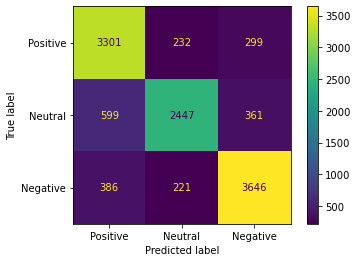

In [ ]:
confusion_matrix = metrics.confusion_matrix(y_test,y_pred)

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = ['Positive', 'Neutral', 'Negative'])
cm_display.plot()
plt.show()

In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.77      0.86      0.81      3832
           1       0.84      0.72      0.78      3407
           2       0.85      0.86      0.85      4253

    accuracy                           0.82     11492
   macro avg       0.82      0.81      0.81     11492
weighted avg       0.82      0.82      0.82     11492



* SVM with polynomial kernel

In [ ]:
SVMp = SVC(C=1.0, kernel='poly', degree=8, gamma='auto')
SVMp.fit(X_train_dtm, y_train)
Y_pred = SVMp.predict(X_test_dtm)
pickle.dump(SVMp, open('SVMp.pkl', 'wb'))

In [ ]:
print('\nSupport Vector Machine with Polynomial kernel')
print('Accuracy Score: ',metrics.accuracy_score(y_test,Y_pred)*100,'%',sep='')


Support Vector Machine with Polynomial kernel
Accuracy Score: 37.008353637312915%


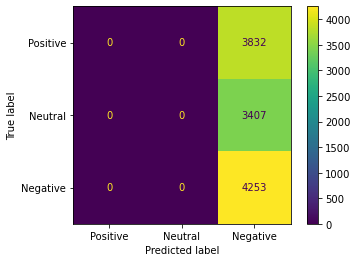

In [ ]:
confusion_matrix = metrics.confusion_matrix(y_test,Y_pred)

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = ['Positive', 'Neutral', 'Negative'])
cm_display.plot()
plt.show()

In [ ]:
print(classification_report(y_test, Y_pred))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00      3832
           1       0.00      0.00      0.00      3407
           2       0.37      1.00      0.54      4253

    accuracy                           0.37     11492
   macro avg       0.12      0.33      0.18     11492
weighted avg       0.14      0.37      0.20     11492



C:\Users\minahil\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\minahil\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\minahil\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


* SVM with RBF(Radius Bases Function)

In [ ]:
SVMr = SVC(C=1.0, kernel='rbf')
SVMr.fit(X_train_dtm, y_train)
Y_predict = SVMr.predict(X_test_dtm)
pickle.dump(SVMr, open('SVMr.pkl', 'wb'))

In [ ]:
print('\nSupport Vector Machine with rbf kernel')
print('Accuracy Score: ',metrics.accuracy_score(y_test,Y_predict)*100,'%',sep='')


Support Vector Machine with rbf kernel
Accuracy Score: 88.73999303863556%


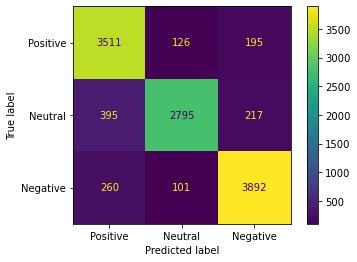

In [ ]:
confusion_matrix = metrics.confusion_matrix(y_test,Y_predict)

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = ['Positive', 'Neutral', 'Negative'])
cm_display.plot()
plt.show()

In [ ]:
print(classification_report(y_test, Y_predict))

              precision    recall  f1-score   support

           0       0.84      0.92      0.88      3832
           1       0.92      0.82      0.87      3407
           2       0.90      0.92      0.91      4253

    accuracy                           0.89     11492
   macro avg       0.89      0.88      0.89     11492
weighted avg       0.89      0.89      0.89     11492



* SVM with sigmoid

In [ ]:
SVMs = SVC(C=1.0, kernel='sigmoid')
SVMs.fit(X_train_dtm, y_train)
Y_prediction = SVMs.predict(X_test_dtm)
pickle.dump(SVMs, open('SVMs.pkl', 'wb'))

In [ ]:
print('\nSupport Vector Machine with sigmoid kernel')
print('Accuracy Score: ',metrics.accuracy_score(y_test,Y_prediction)*100,'%',sep='')


Support Vector Machine with sigmoid kernel
Accuracy Score: 63.27880264531848%


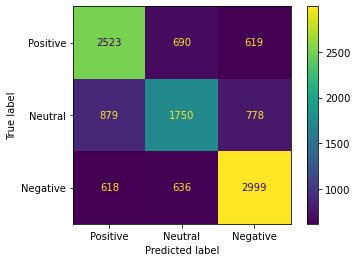

In [ ]:
confusion_matrix = metrics.confusion_matrix(y_test,Y_prediction)

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = ['Positive', 'Neutral', 'Negative'])
cm_display.plot()
plt.show()

In [ ]:
print(classification_report(y_test, Y_prediction))

              precision    recall  f1-score   support

           0       0.63      0.66      0.64      3832
           1       0.57      0.51      0.54      3407
           2       0.68      0.71      0.69      4253

    accuracy                           0.63     11492
   macro avg       0.63      0.63      0.63     11492
weighted avg       0.63      0.63      0.63     11492



## RANDOM FOREST

In [ ]:
RTC = RandomForestClassifier(n_estimators=100)
RTC.fit(X_train_dtm, y_train)
y_predict = RTC.predict(X_test_dtm)
pickle.dump(RTC, open('RTC.pkl', 'wb'))

In [ ]:
print('\nRandom Forest')
print('Accuracy Score: ',metrics.accuracy_score(y_test,y_predict)*100,'%',sep='')


Random Forest
Accuracy Score: 92.24678036895232%


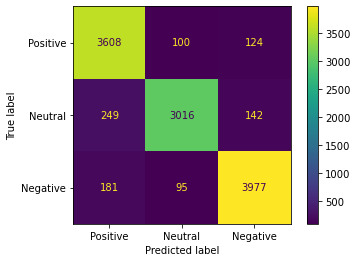

In [ ]:
confusion_matrix = metrics.confusion_matrix(y_test,y_predict)

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = ['Positive', 'Neutral', 'Negative'])
cm_display.plot()
plt.show()

In [ ]:
print(classification_report(y_test, y_predict))

              precision    recall  f1-score   support

           0       0.89      0.94      0.92      3832
           1       0.94      0.89      0.91      3407
           2       0.94      0.94      0.94      4253

    accuracy                           0.92     11492
   macro avg       0.92      0.92      0.92     11492
weighted avg       0.92      0.92      0.92     11492



## NAIVE BAYES

In [ ]:
NBC = MultinomialNB()
NBC.fit(X_train_dtm, y_train)
y_predicted = NBC.predict(X_test_dtm)
pickle.dump(NBC, open('NBC.pkl', 'wb'))

In [ ]:
print('\nNaiva Bayes')
print('Accuracy Score: ',metrics.accuracy_score(y_test,y_predicted)*100,'%',sep='')


Naiva Bayes
Accuracy Score: 74.62582666202576%


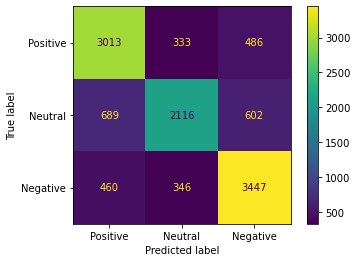

In [ ]:
confusion_matrix = metrics.confusion_matrix(y_test,y_predicted)

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = ['Positive', 'Neutral', 'Negative'])
cm_display.plot()
plt.show()

In [ ]:
print(classification_report(y_test, y_predicted))

              precision    recall  f1-score   support

           0       0.72      0.79      0.75      3832
           1       0.76      0.62      0.68      3407
           2       0.76      0.81      0.78      4253

    accuracy                           0.75     11492
   macro avg       0.75      0.74      0.74     11492
weighted avg       0.75      0.75      0.74     11492



## LOGISTIC REGRESSION

In [ ]:
LRC = LogisticRegression(C=1, solver="liblinear",max_iter=200)
LRC.fit(X_train_dtm, y_train)
y_prediction = LRC.predict(X_test_dtm)
pickle.dump(LRC, open('LRC.pkl', 'wb'))

In [ ]:
print('\nLogistic Regression')
print('Accuracy Score: ',metrics.accuracy_score(y_test,y_prediction)*100,'%',sep='')


Logistic Regression
Accuracy Score: 80.95196658545075%


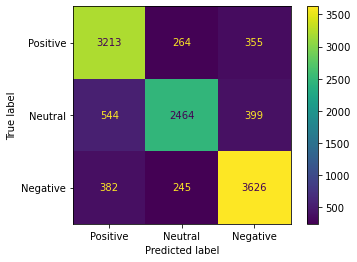

In [ ]:
confusion_matrix = metrics.confusion_matrix(y_test,y_prediction)

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = ['Positive', 'Neutral', 'Negative'])
cm_display.plot()
plt.show()

In [ ]:
print(classification_report(y_test, y_prediction))

              precision    recall  f1-score   support

           0       0.78      0.84      0.81      3832
           1       0.83      0.72      0.77      3407
           2       0.83      0.85      0.84      4253

    accuracy                           0.81     11492
   macro avg       0.81      0.80      0.81     11492
weighted avg       0.81      0.81      0.81     11492



## Testing on unseen data

In [ ]:
Vector = CountVectorizer(stop_words='english', ngram_range = (1,1), max_df = .80, min_df = 4)
Vector.fit(X_train)
X_dtm = Vector.transform(X_train)

#Input tweet
print('\nTest a custom review message')
print('Enter review to be analysed:', end =" ")
test = []
test.append(input())

#tokenizing the text
test_dtm = Vector.transform(test)

#Random Forest Model
#load saved model
loaded_model = pickle.load(open('RTC.pkl', 'rb'))

#make pediction
predLabel = loaded_model.predict(test_dtm)
if predLabel==0:
    result='Positive'
elif predLabel==1:
    result='Neutral'
else:
    result='Negative'


#Display Output
print('The review is predicted as ',result)


Test a custom review message
Enter review to be analysed: ahmad play cricket too much
The review is predicted as  Negative


# GRAPHICAL USER INTERFACE

In [ ]:
#importing libraries
#for the GUI, we have use tkinter
import tkinter as tk
from tkinter.constants import RIGHT
from tkinter import *
import pickle
from tkinter import messagebox
from PIL import Image, ImageTk
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer

In [ ]:
#creating the first window to appear
root = Tk()
#size of window
root.geometry('500x500')
root.minsize(200,100)
root.maxsize(1500,1200)
#title to show on the top
root.title("SENTIMENT ANALYSIS")

#dividing our window screen in four frames
frame1 = tk.Frame(master=root, height=150, bg='yellowgreen', borderwidth=4, relief=SUNKEN)
frame1.pack(side=TOP, fill=tk.X)

frame2 = tk.Frame(master=root, height=50, bg='yellowgreen', borderwidth=4, relief=SUNKEN)
frame2.pack(fill=tk.X)

frame3 = tk.Frame(master=root, height=250, bg='yellowgreen', borderwidth=4, relief=SUNKEN)
frame3.pack(fill=tk.X)

frame4 = tk.Frame(master=root, height=850, bg='yellowgreen', borderwidth=4, relief=SUNKEN)
frame4.pack(side=BOTTOM, fill=tk.X)

#In the first frame of our first window appear, we have label
la = Label(frame1, text ="Sentiment Analysis of tweets/review using Random Forest Classifier",fg='YellowGreen', bg='White', padx=5, pady=10, font=150)
la.pack(pady = 20)

#In the third frame, we attach image
img = ImageTk.PhotoImage(Image.open("ps.jpg"))
im_label = Label(frame3, image=img)
im_label.pack()

#On clicking the first very first button in our second frame of very first window, this new window will appear
def about():
    # Toplevel object which will be treated as a new window
    ten = Toplevel(root)
    # sets the title of the
    ten.title("ABOUT US")
    #setting size
    ten.geometry('500x500')
    ten.minsize(200,100)
    ten.maxsize(1500,1200)

    #creating four frames
    fr1 = tk.Frame(master=ten, height=80, bg="Orange")
    fr1.pack(side=TOP, fill=tk.X)

    fr2 = tk.Frame(master=ten, height=150, bg="Orange")
    fr2.pack(fill=tk.X)

    fr3 = tk.Frame(master=ten, height=400, bg="Orange", relief=SUNKEN)
    fr3.pack(fill=tk.X)

    fr4 = tk.Frame(master=ten, height=400, bg="Orange")
    fr4.pack(fill=tk.X)

    #In first frame, haing label
    o = Label(fr1, text ="About Team Members",fg='Orange', bg='White', padx=5, pady=10, font=('Arial',16,'bold'), borderwidth=2, relief=GROOVE)
    o.pack(pady = 20)

    #creating class to create the table
    class Table:

        def __init__(self,root):

            # code for creating table
            for i in range(total_rows):
                for j in range(total_columns):

                    self.e = Entry(root, width=40, fg='Orange',
                                   font=('Arial',14,'bold'))

                    self.e.grid(row=i, column=j)
                    self.e.insert(END, lst[i][j])

    # take the data
    lst = [('#','NAME','REGISTRATION #'),
           (1,'Minahil Sadiq','SP20-BCS-023'),
           (2,'Sheeza Ali','SP20-BCS-005'),
           (3,'Muhammad Zubair','SP20-BCS-025'),
           (4,'Ayesha Bibi','SP20-BCS-152')]

    # find total number of rows and
    # columns in list
    total_rows = len(lst)
    total_columns = len(lst[0])

    #showing table in our third frame
    t = Table(fr3)

#In the second frame of our main window we have created buttons which have links to next new window
#first button is ''about us''
b1 = Button(frame2, fg="Green", bg="White", text="About Us", command=about)
b1.pack(side=LEFT, padx=25)

#On clicking the second button in our second frame of very first window, this new window will appear
def aboutt():
    # Toplevel object which will be treated as a new window
    new = Toplevel(root)
    #title
    new.title("ABOUT")
    #size
    new.geometry('500x500')
    new.minsize(200,100)
    new.maxsize(1500,1200)

    #creating nine frames
    f1 = tk.Frame(master=new, height=80, bg="Pink")
    f1.pack(side=TOP, fill=tk.X)

    f2 = tk.Frame(master=new, height=40, bg="Pink")
    f2.pack(fill=tk.X)

    f3 = tk.Frame(master=new, height=250, bg="Pink")
    f3.pack(fill=tk.X)

    f4 = tk.Frame(master=new, height=40, bg="Pink")
    f4.pack(fill=tk.X)

    f5 = tk.Frame(master=new, height=250, bg="Pink")
    f5.pack(fill=tk.X)

    f6 = tk.Frame(master=new, height=40, bg="Pink")
    f6.pack(fill=tk.X)

    f7 = tk.Frame(master=new, height=250, bg="Pink")
    f7.pack(fill=tk.X)

    f8 = tk.Frame(master=new, height=40, bg="Pink")
    f8.pack(fill=tk.X)

    f9 = tk.Frame(master=new, height=250, bg="Pink")
    f9.pack(fill=tk.X)

    f10 = tk.Frame(master=new, height=550, bg="Pink")
    f10.pack(fill=tk.X)

    #in all nine frames we have text to represent
    o = Label(f1, text ="About Sentiment Analysis",fg='Black', bg='Pink', padx=5, pady=10, borderwidth=2, relief=GROOVE, font =('Arial',16,'bold'))
    o.pack(pady = 20)

    h = Label(f2, text ="What is Sentiment Analysis?",fg='Black',bg='Pink', padx=5, font=140)
    h.pack(side=LEFT, padx = 15)

    p = Label(f3, text="Sentiment analysis, also referred to as opinion mining, is an approach to natural language processing (NLP)\n that identifies the emotional tone behind a body of text. This is a popular way for organizations to determine and categorize \n opinions about a product, service, or idea. It involves the use of data mining, machine learning (ML) \n and artificial intelligence (AI) to mine text for sentiment and subjective information.", fg='Black',bg='Pink', padx=5, pady=10, font=('Arial',13,'italic'))
    p.pack(pady=5)

    i = Label(f4, text ="Why Twitter Sentiment Analysis Important?",fg='Black',bg='Pink', padx=5, font=140)
    i.pack(side=LEFT, padx = 15)

    k = Label(f5, text="Todays era is of social media. One of the biggest platform in social media is the twitter, where on average 6000\n tweets are tweeted per second. Everyday 500 million of tweets are being produced related to different topics. Now the data\n or information gained through twitter can be categorized as positive, negative or neutral. And there is need to\n analyze these data in such a way to understand people reviews or their thinking related to particular topic.", fg='Black',bg='Pink', padx=5, pady=10, font=('Arial',13,'italic'))
    k.pack(pady=5)

    q = Label(f6, text ="Machine Learning Classifier Used:",fg='Black',bg='Pink', padx=5, font=140)
    q.pack(side=LEFT, padx = 15)

    r = Label(f7, text="We have used Random Forest Classifier to train our model on the dataset we have, after the training we did\n test our model and it give us about 92% accuracy. Therefore here we are using Random Forest as it gives us a good accuracy. ", fg='Black',bg='Pink', padx=5, pady=10, font=('Arial',13,'italic'))
    r.pack(pady=5)

    s = Label(f8, text ="Methodology:",fg='Black',bg='Pink', padx=5, font=130)
    s.pack(side=LEFT, padx = 15)

    t = Label(f9, text="We have dataset from the kaggle, The very first step after loading the data is to clear the data, we remove\n all null,duplicate instances and the columns which were not necessary. The second step was visualizing the data (we make a pie chart).\n In the third step we clean our tweets by removing stopwords, doing stemming and lemmatizing. And then tokenizing the\n processed tweets to extract features. In the next step we split the data in 80:20 ratio and train our models.", fg='Black',bg='Pink', padx=5, pady=10, font=('Arial',13,'italic'))
    t.pack(pady=5)


#In the second frame of our main window we have created buttons which have links to next new window
#second button is ''about project''
b2 = Button(frame2, fg="Green", bg="White", text="About Project", command=aboutt)
b2.pack(side=LEFT, padx=25)

#On clicking the third button in our second frame of very first window, this new window will appear
def sentiment():
    # Toplevel object which will be treated as a new window
    new = Toplevel(root)
    #title
    new.title("SENTIMENT ANALYZER")
    #size set
    new.geometry('500x500')
    new.minsize(200,100)
    new.maxsize(1500,1200)

    #five frames have created
    fra1 = tk.Frame(master=new, height=80, bg="White")
    fra1.pack(side=TOP, fill=tk.X)

    fra2 = tk.Frame(master=new, height=40, bg="Magenta")
    fra2.pack(fill=tk.X)

    fra3 = tk.Frame(master=new, height=250, bg='Magenta')
    fra3.pack(fill=tk.X)

    fra4 = tk.Frame(master=new, height=400, bg ="White")
    fra4.pack(fill=tk.X)

    fra5 = tk.Frame(master=new, height=500, bg ="White")
    fra5.pack(fill=tk.X)

    #label in first frame
    x = Label(fra1, text ="Analyze text using Random Forest Clasifier",fg='Magenta', padx=5,pady=10, font=('Arial',16,'bold'), relief=GROOVE)
    x.pack(pady = 20)

    #''Overview'' text in second frame
    g = Label(fra2, text ="Overview:",fg='White', bg='Magenta', padx=5, font=130)
    g.pack(side=LEFT, padx = 30)

    #detail of ''Overview'' in third frame
    j = Label(fra3, text="This tool will allow you to conduct sentiment analysis on virtually any text written in english. This will\n compute sentiment analysis and will predict the text as 'Negative', 'Positive', or 'Neutral'. ", fg='White',bg='Magenta', padx=5, pady=10, font=('Arial',14,'italic'))
    j.pack(pady=5)

    #loading the new image in frame4, side it to left size
    im = ImageTk.PhotoImage(Image.open("icon.jpg"))
    y = Label(fra4, image=im)
    y.image = im
    y.pack(side="left",padx = 50, pady=10)

    #On the right of the frame4 created the entry field to enter new text
    text = Label(fra4, text="Enter Text in below box to predict the sentiment:", bg = 'White', fg='Magenta', font=130)
    text.pack(pady=10)
    text_entrybox = Text(fra4, width=50, height= 10, bg='White', fg='Magenta', state = NORMAL, relief = SUNKEN)
    text_entrybox.pack()

    #function to be called on clicking the clear_button
    def clear():
        text_entrybox.delete(1.0,END)

    #function to be called on clicking the analyze_button
    def analyze():
        data = {
            'content' :[text_entrybox.get(1.0, END)]
        }

        #saving the new record in csv data format
        X_test = pd.DataFrame(data)
        test = X_test['content']

        #tokenizing: extracting the features
        Vector = CountVectorizer(stop_words='english', ngram_range = (1,1), max_df = .80, min_df = 4)
        Vector.fit(X_train)
        X_dtm = Vector.transform(X_train)

        test_dtm = Vector.transform(test)

        #loading our save model to prdeict the new text enter
        #random forest classifier is used
        pickled_model_rtc = pickle.load(open('RTC.pkl', 'rb'))
        predicted_rtc = pickled_model_rtc.predict(test_dtm)

        if predicted_rtc==0:
            result='Positive'
        elif predicted_rtc==1:
            result='Neutral'
        else:
            result='Negative'

        #showing the result in the messagebox
        messagebox.showinfo("Sentiment", result)

    #created two buttons
    #to analyze the new text
    Analyze_button = Button(fra4, fg="Magenta", bg="White", text="Analyze", command=analyze)
    Analyze_button.pack()
    #to clear the text
    clear_button = Button(fra4, fg="Magenta", bg="White", text="Clear", command=clear)
    clear_button.pack()

#In the second frame of our main window we have created buttons which have links to next new window
#third button is ''Analyze sentiment of text''
b3 = Button(frame2, fg="Green", bg="White", text="Analyze Sentiment", command=sentiment)
b3.pack(side=LEFT, padx=25)

In [ ]:
root.mainloop()